## Sagnac Frequency - Tilt Correction

## Imports

In [3]:
import os
import gc
import matplotlib.pyplot as plt
import numpy as np

from datetime import datetime, date
from pandas import DataFrame, read_pickle, date_range, concat, read_csv
from obspy import UTCDateTime, read, Trace, Stream
from scipy.signal import hilbert

from functions.get_fft import __get_fft
from functions.multitaper_psd import __multitaper_psd
from functions.welch_psd import __welch_psd
from functions.compute_cwt import __compute_cwt
from functions.reduce import __reduce
from functions.multitaper_coherence import __multitaper_coherence
from functions.conversion_to_tilt import __conversion_to_tilt

from andbro__read_sds import __read_sds
from andbro__readYaml import __readYaml

In [4]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
    bay_path = '/home/andbro/ontap-ffb-bay200/'
    lamont_path = '/home/andbro/lamont/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/import/ontap-ffb-bay200/'
    lamont_path = '/lamont/'
elif os.uname().nodename in ['lin-ffb-01', 'ambrym', 'hochfelln']:
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/import/ontap-ffb-bay200/'
    lamont_path = '/lamont/'

In [5]:
def __get_tides(tbeg, tend, component="N", typ="acc", df=3600):

    from pygtide import predict_series
    from numpy import arange, pi
    from obspy import UTCDateTime

    # ROMY
    lat = 48.162941
    lon = 11.275501
    height = 570

    startdate = str(UTCDateTime(tbeg).date)
    duration =  (UTCDateTime(tend) -  UTCDateTime(tbeg)) /3600 # in hours
    sampling_rate = df # in seconds

    # creat time vector
    times = arange(0, duration+df/3600, df/3600)

    # prepare arguments
    args = (lat, lon, height, startdate, duration, sampling_rate)

    # specify station azimuth clockwise from north (=0)
    if component == "N":
        statazimut = 0
    elif component == "E":
        statazimut = 90



    if typ == "rad":
        # tides /= 9.81
        tides = predict_series(*args, statgravit=0, statazimut=statazimut, tidalcompo=1) # tilt

        # from mas to rad
        tides = tides * pi / 648000000

    elif typ == "acc":
        tides = predict_series(*args, statazimut=statazimut, tidalcompo=0) # horizontal acceleration

        # from nano to acc
        tides *= 1e-9

    elif typ == "str":
        tides = predict_series(*args, statazimut=statazimut, tidalcompo=5) # horizontal strain

        # from nano to str
        tides *= 1e-9

    return times, tides

## Configurations

In [276]:
config = {}

config['path_to_sds'] = archive_path+"romy_archive/"

config['tbeg'] = UTCDateTime("2024-03-09 00:00")
config['tend'] = UTCDateTime("2024-05-31 00:00")

# path to Sagnac data
config['path_to_autodata'] = archive_path+f"romy_autodata/"

config['path_to_data'] = data_path+"sagnac_frequency/data/backscatter/"

config['path_to_figs'] = data_path+"tiltmeter/figures/"

config['date_str'] = f"{config['tbeg'].date}_{config['tend'].date}"

## Configurations

### Load LXX Log

In [7]:
from functions.load_lxx import __load_lxx
from functions.get_lxx_intervals import __get_lxx_intervals

# load LXX log data
lxx = __load_lxx(config['tbeg'], config['tend'], archive_path)

# extract time intervals
lxx_t1, lxx_t2 = __get_lxx_intervals(lxx.datetime)


### Load Tilt Data

  -> converted data of ROMYT


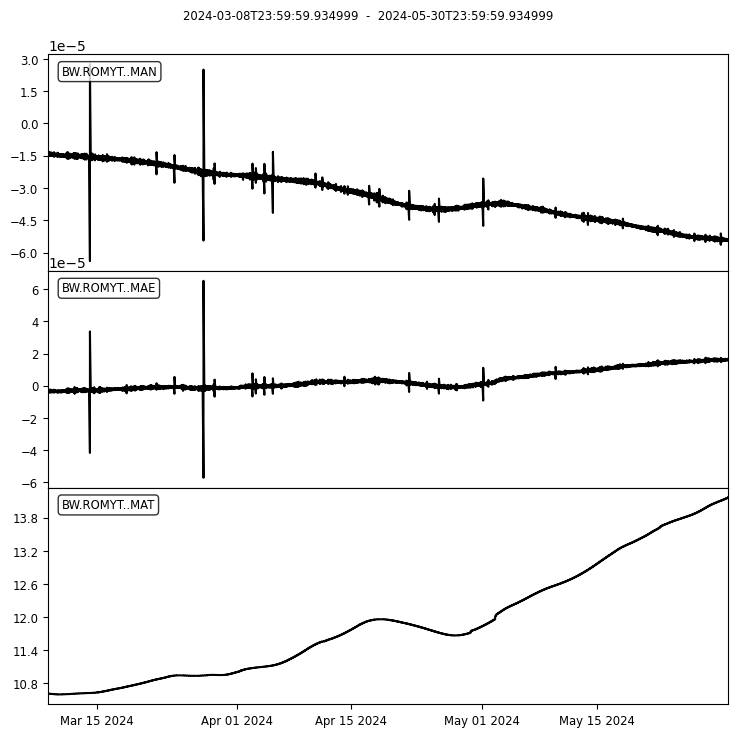

In [8]:
## tiltmeter configurations
confTilt = __readYaml(root_path+"Documents/ROMY/tiltmeter/", "tiltmeter.conf")


# tromy0 =  __read_sds(config['path_to_sds'], "BW.DROMY..LAN", config['tbeg']-600, config['tend']+600)
# tromy0 += __read_sds(config['path_to_sds'], "BW.DROMY..LAE", config['tbeg']-600, config['tend']+600)
# tromy0 += __read_sds(config['path_to_sds'], "BW.DROMY..LAT", config['tbeg']-600, config['tend']+600)

# tromy0 = __conversion_to_tilt(tromy0, confTilt['BROMY'])


tromy0 = Stream()
tromy0 += __read_sds(config['path_to_sds'], "BW.ROMYT..MAN", config['tbeg']-600, config['tend']+600)
tromy0 += __read_sds(config['path_to_sds'], "BW.ROMYT..MAE", config['tbeg']-600, config['tend']+600)
tromy0 += __read_sds(config['path_to_sds'], "BW.ROMYT..MAT", config['tbeg']-600, config['tend']+600)

tromy0 = __conversion_to_tilt(tromy0, confTilt['ROMYT'])

tromy0 = tromy0.trim(config['tbeg'], config['tend'])

tromy0.plot(equal_scale=False);

gc.collect();

### Compare Temperature and Tilt

830 830 830
Nshift:  -69 Tshift:  -596160.0 CC:  -0.8000751684160545
Nshift:  15 Tshift:  129600.0 CC:  0.9654745484036913


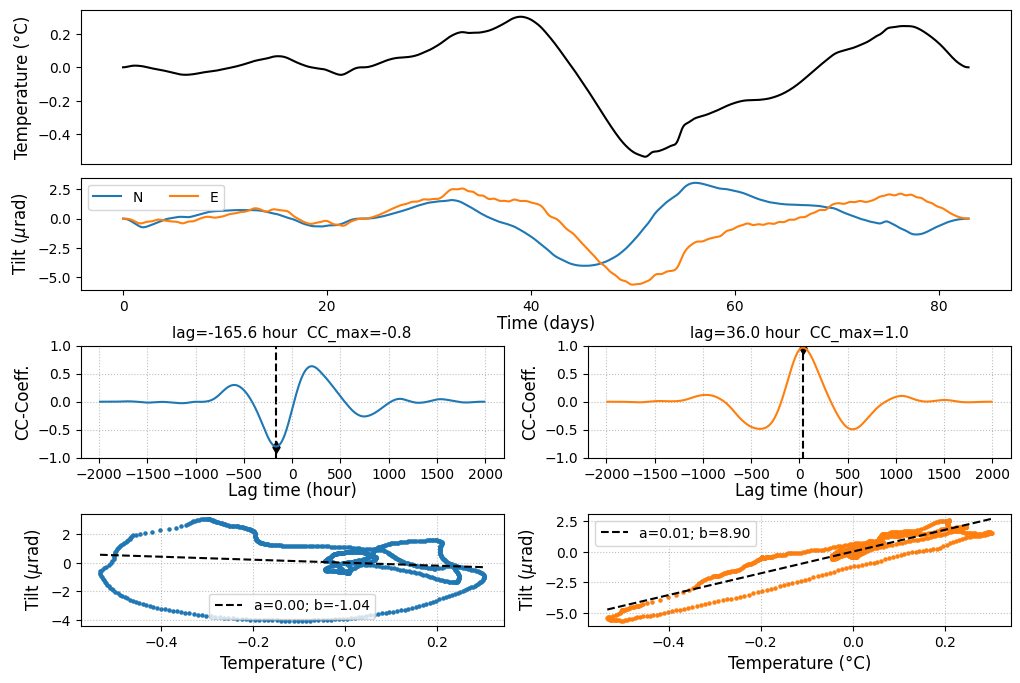

In [9]:
def __compare_tilt_temperature(st0, fmin=None, fmax=1/3600):

    from obspy.signal.cross_correlation import correlate, xcorr_max
    from numpy import nan_to_num, arange, array, linspace
    from matplotlib.gridspec import GridSpec
    from functions.compute_orthogonal_distance_regression import __compute_orthogonal_distance_regression
    from functions.smoothing import __smooth


    tlp = st0.copy()

    tlp = tlp.detrend("linear")

    tlp = tlp.taper(0.1, type="cosine")

    if fmin is None:
        tlp = tlp.filter("lowpass", freq=fmax, corners=4, zerophase=True)
    else:
        tlp = tlp.filter("bandpass", freqmin=fmin, freqmax=fmax, corners=4, zerophase=True)

    tlp = tlp.resample(10*fmax, no_filter=True)

    tlp = tlp.merge()


    dt = tlp[0].stats.delta

    times = tlp[0].times()/86400

    arr0 = nan_to_num(tlp.select(channel="*T")[0].data, 0)
    arr1 = nan_to_num(tlp.select(channel="*N")[0].data, 0)
    arr2 = nan_to_num(tlp.select(channel="*E")[0].data, 0)

#     dt = st0[0].stats.delta
#     times = st0[0].times()/86400

#     arr0 = __smooth(nan_to_num(st0.select(channel="*T")[0].data, 0), 3600)
#     arr1 = __smooth(nan_to_num(st0.select(channel="*N")[0].data, 0), 3600)
#     arr2 = __smooth(nan_to_num(st0.select(channel="*E")[0].data, 0), 3600)

    print(len(arr0), len(arr1), len(arr2))

    # arr1 = __interpolate_nan(tromy_lp.select(channel="*T")[0].data)
    # arr2 = __interpolate_nan(tromy_lp.select(channel="*N")[0].data)

    Nshift = len(arr0)

    ccf1 = correlate(arr0, arr1, shift=Nshift, demean=False, normalize='naive', method='fft')
    ccf2 = correlate(arr0, arr2, shift=Nshift, demean=False, normalize='naive', method='fft')

    cclags = arange(-Nshift, Nshift+1) * dt

    shift1, value1 = xcorr_max(ccf1)
    shift2, value2 = xcorr_max(ccf2)

    print("Nshift: ", shift1, "Tshift: ", shift1*dt, "CC: ", value1)
    print("Nshift: ", shift2, "Tshift: ", shift2*dt, "CC: ", value2)


    b1, a1 = __compute_orthogonal_distance_regression(arr0, arr1, xerr=None, yerr=None, bx=None, by=None)
    b2, a2 = __compute_orthogonal_distance_regression(arr0, arr2, xerr=None, yerr=None, bx=None, by=None)

    xxx = linspace(arr0.min(), arr0.max(), 100)

    Nrow, Ncol = 4, 2
    font = 12

    fig = plt.figure(figsize=(12, 8))

    gs0 = GridSpec(Nrow, Ncol, figure=fig, hspace=0)
    gs = GridSpec(Nrow, Ncol, figure=fig, hspace=0.5)

    ax1 = fig.add_subplot(gs0[0, :])
    ax2 = fig.add_subplot(gs[1, :])
    ax3 = fig.add_subplot(gs[2, :1])
    ax4 = fig.add_subplot(gs[2, 1:])
    ax5 = fig.add_subplot(gs[3, :1])
    ax6 = fig.add_subplot(gs[3, 1:])

    plt.subplots_adjust(hspace=0.35)

    ax1.plot(times, arr0, color="black")
    ax1.set_ylabel("Temperature (°C)", fontsize=font)
    ax1.get_xaxis().set_visible(False)

    ax2.plot(times, arr1*1e6, label="N")
    ax2.plot(times, arr2*1e6, label="E")
    ax2.legend(ncol=2)
    ax2.set_ylabel("Tilt ($\mu$rad)", fontsize=font)
    ax2.set_xlabel("Time (days)", fontsize=font, labelpad=1)

    ax3.plot(cclags/3600, ccf1, color="tab:blue")
    # ax3.legend(loc=1)
    ax3.set_ylabel("CC-Coeff.", fontsize=font)
    ax3.set_xlabel("Lag time (hour)", fontsize=font, labelpad=0)
    ax3.set_ylim(-1, 1)
    ax3.axvline(shift1*dt/3600, -1, 1, color="k", ls="--", zorder=0)
    ax3.scatter(shift1*dt/3600, value1, color="k", marker="d", zorder=0)
    ll = f"lag={round(shift1*dt/3600, 1)} hour  CC_max={round(value1, 1)}"
    ax3.set_title(ll, fontsize=font-1)
    # ax3.text(.005, .97, ll, ha='left', va='top', transform=ax3.transAxes, fontsize=font)

    ax4.plot(cclags/3600, ccf2, color="tab:orange")
    # ax4.legend(loc=1)
    ax4.set_ylabel("CC-Coeff.", fontsize=font)
    ax4.set_xlabel("Lag time (hour)", fontsize=font, labelpad=0)
    ax4.set_ylim(-1, 1)
    ax4.axvline(shift2*dt/3600, -1, 1, color="k", ls="--", zorder=0)
    ax4.scatter(shift2*dt/3600, value2, color="k", marker="d", zorder=0)
    ll = f"lag={round(shift2*dt/3600, 1)} hour  CC_max={round(value2, 1)}"
    ax4.set_title(ll, fontsize=font-1)
    # ax4.text(.005, .97, ll, ha='left', va='top', transform=ax4.transAxes, fontsize=font)

    ax5.scatter(arr0, arr1*1e6, color="tab:blue", s=5)
    ax5.plot(xxx, (a1+b1*xxx)*1e6, ls="--", color="k", label=f"a={a1*1e6:.2f}; b={b1*1e6:.2f}")
    ax5.set_xlabel("Temperature (°C)", fontsize=font)
    ax5.set_ylabel("Tilt ($\mu$rad)", fontsize=font)
    ax5.legend()

    ax6.scatter(arr0, arr2*1e6, color="tab:orange", s=5)
    ax6.plot(xxx, (a2+b2*xxx)*1e6, ls="--", color="k", label=f"a={a2*1e6:.2f}; b={b2*1e6:.2f}")
    ax6.set_xlabel("Temperature (°C)", fontsize=font)
    ax6.set_ylabel("Tilt ($\mu$rad)", fontsize=font)
    ax6.legend()

    for ax in [ax3, ax4, ax5, ax6]:
        ax.grid(ls=":", alpha=0.5, zorder=0, color="grey")

    plt.show();
    return fig

fig = __compare_tilt_temperature(tromy0, fmin=None, fmax=1/(24*3600))

fig.savefig(config['path_to_figs']+f"SF_Tilt_temperature_dependance_{config['date_str']}.png", format="png", dpi=150, bbox_inches='tight')


In [10]:
fmin = None
fmax = 1/(24*3600)

tlp = tromy0.copy()

tlp = tlp.detrend("linear")

tlp = tlp.taper(0.1, type="cosine")

if fmin is None:
    tlp = tlp.filter("lowpass", freq=fmax, corners=4, zerophase=True)
else:
    tlp = tlp.filter("bandpass", freqmin=fmin, freqmax=fmax, corners=4, zerophase=True)

tlp = tlp.resample(10*fmax, no_filter=True)

tlp = tlp.merge("interpolate")


Nshift:  -69 Tshift:  -596160.0 CC:  -0.8000751684160545
Nshift:  15 Tshift:  129600.0 CC:  0.9654745484036913


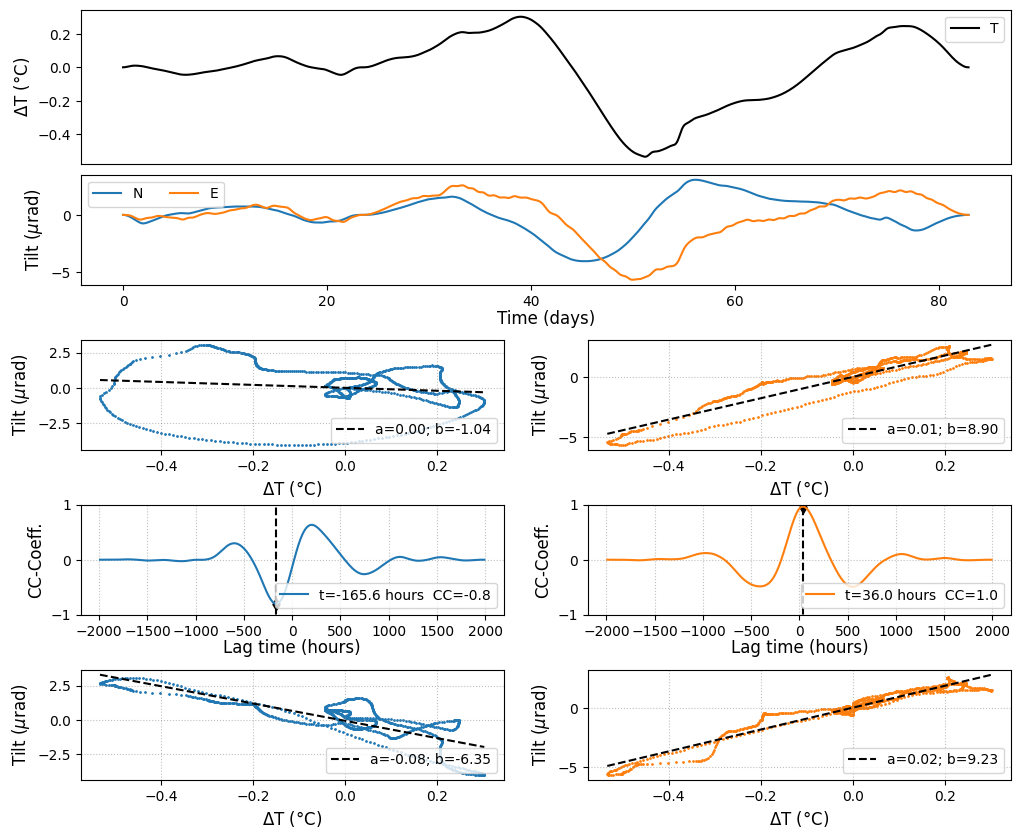

In [11]:
def __compare_tilt_pressure(st0):

    from obspy.signal.cross_correlation import correlate, xcorr_max
    from numpy import nan_to_num, arange, array, linspace, imag, roll
    from matplotlib.gridspec import GridSpec
    from functions.compute_orthogonal_distance_regression import __compute_orthogonal_distance_regression
    from functions.smoothing import __smooth
    from scipy.signal import hilbert

    _tlp = st0.copy()

    dt = _tlp[0].stats.delta

    yscale, yunit = 1e6, r"$\mu$"

    tscale, tunit = 1/86400, "days"

    times = _tlp[0].times()*tscale

    ch = "T"

    arr0 = nan_to_num(_tlp.select(component=ch)[0].data, 0)
    arr1 = nan_to_num(_tlp.select(component="N")[0].data, 0)
    arr2 = nan_to_num(_tlp.select(channel="*E")[0].data, 0)


    Nshift = len(arr0)

    ccf1 = correlate(arr0, arr1, shift=Nshift, demean=False, normalize='naive', method='fft')
    ccf2 = correlate(arr0, arr2, shift=Nshift, demean=False, normalize='naive', method='fft')

    cclags = arange(-Nshift, Nshift+1) * dt

    shift1, value1 = xcorr_max(ccf1)
    shift2, value2 = xcorr_max(ccf2)

    arr1_shifted = roll(arr1, shift1)
    arr2_shifted = roll(arr2, shift2)

    print("Nshift: ", shift1, "Tshift: ", shift1*dt, "CC: ", value1)
    print("Nshift: ", shift2, "Tshift: ", shift2*dt, "CC: ", value2)


    b1, a1 = __compute_orthogonal_distance_regression(arr0, arr1, xerr=None, yerr=None, bx=None, by=None)
    b2, a2 = __compute_orthogonal_distance_regression(arr0, arr2, xerr=None, yerr=None, bx=None, by=None)

    b1_shifted, a1_shifted = __compute_orthogonal_distance_regression(arr0, arr1_shifted, xerr=None, yerr=None, bx=None, by=None)
    b2_shifted, a2_shifted = __compute_orthogonal_distance_regression(arr0, arr2_shifted, xerr=None, yerr=None, bx=None, by=None)

    xxx = linspace(arr0.min(), arr0.max(), 100)

    Nrow, Ncol = 5, 2
    font = 12

    fig = plt.figure(figsize=(12, 10))

    gs0 = GridSpec(Nrow, Ncol, figure=fig, hspace=0)
    gs = GridSpec(Nrow, Ncol, figure=fig, hspace=0.5)

    ax1 = fig.add_subplot(gs0[0, :])
    ax2 = fig.add_subplot(gs[1, :])
    ax3 = fig.add_subplot(gs[2, :1])
    ax4 = fig.add_subplot(gs[2, 1:])
    ax5 = fig.add_subplot(gs[3, :1])
    ax6 = fig.add_subplot(gs[3, 1:])
    ax7 = fig.add_subplot(gs[4, :1])
    ax8 = fig.add_subplot(gs[4, 1:])

    plt.subplots_adjust(hspace=0.35)

    ax1.plot(times, arr0, color="black", label=f"{ch}")
    ax1.set_ylabel(r"$\Delta$T (°C)", fontsize=font)
    ax1.get_xaxis().set_visible(False)
    ax1.legend(loc=1)

    ax2.plot(times, arr1*yscale, label="N")
    ax2.plot(times, arr2*yscale, label="E")
    ax2.legend(ncol=2)
    ax2.set_ylabel(f"Tilt ({yunit}rad)", fontsize=font)
    ax2.set_xlabel(f"Time ({tunit})", fontsize=font, labelpad=1)


    ax3.scatter(arr0, arr1*yscale, color="tab:blue", s=1)
    ax3.plot(xxx, (a1+b1*xxx)*yscale, ls="--", color="k", label=f"a={a1*yscale:.2f}; b={b1*yscale:.2f}")
    ax3.set_xlabel(r"$\Delta$T (°C)", fontsize=font)
    ax3.set_ylabel(f"Tilt ({yunit}rad)", fontsize=font)
    ax3.legend(loc=4)

    ax4.scatter(arr0, arr2*yscale, color="tab:orange", s=1)
    ax4.plot(xxx, (a2+b2*xxx)*yscale, ls="--", color="k", label=f"a={a2*yscale:.2f}; b={b2*yscale:.2f}")
    ax4.set_xlabel(r"$\Delta$T (°C)", fontsize=font)
    ax4.set_ylabel(f"Tilt ({yunit}rad)", fontsize=font)
    ax4.legend(loc=4)

    ll = f"t={round(shift1/3600*dt, 1)} hours  CC={round(value1, 1)}"
    ax5.plot(cclags/3600, ccf1, color="tab:blue", label=ll)
    ax5.set_ylabel("CC-Coeff.", fontsize=font)
    ax5.set_xlabel("Lag time (hours)", fontsize=font, labelpad=0)
    ax5.set_ylim(-1, 1)
    ax5.axvline(shift1/3600*dt, -1, 1, color="k", ls="--", zorder=0)
    ax5.scatter(shift1/3600*dt, value1, color="k", marker="d", zorder=0)
    ax5.legend(loc=4)
    # ax5.text(.005, .97, ll, ha='left', va='top', transform=ax3.transAxes, fontsize=font)

    ll = f"t={round(shift2/3600*dt, 1)} hours  CC={round(value2, 1)}"
    ax6.plot(cclags/3600, ccf2, color="tab:orange", label=ll)
    ax6.set_ylabel("CC-Coeff.", fontsize=font)
    ax6.set_xlabel("Lag time (hours)", fontsize=font, labelpad=0)
    ax6.set_ylim(-1, 1)
    ax6.axvline(shift2/3600*dt, -1, 1, color="k", ls="--", zorder=0)
    ax6.scatter(shift2/3600*dt, value2, color="k", marker="d", zorder=0)
    ax6.legend(loc=4)
    # ax6.text(.005, .97, ll, ha='left', va='top', transform=ax4.transAxes, fontsize=font)


    ax7.scatter(arr0, arr1_shifted*yscale, color="tab:blue", s=1)
    ax7.plot(xxx, (a1_shifted+b1_shifted*xxx)*yscale, ls="--", color="k", label=f"a={a1_shifted*yscale:.2f}; b={b1_shifted*yscale:.2f}")
    ax7.set_xlabel(r"$\Delta$T (°C)", fontsize=font)
    ax7.set_ylabel(f"Tilt ({yunit}rad)", fontsize=font)
    ax7.legend(loc=4)

    ax8.scatter(arr0, arr2_shifted*yscale, color="tab:orange", s=1)
    ax8.plot(xxx, (a2_shifted+b2_shifted*xxx)*yscale, ls="--", color="k", label=f"a={a2_shifted*yscale:.2f}; b={b2_shifted*yscale:.2f}")
    ax8.set_xlabel(r"$\Delta$T (°C)", fontsize=font)
    ax8.set_ylabel(f"Tilt ({yunit}rad)", fontsize=font)
    ax8.legend(loc=4)

    for ax in [ax3, ax4, ax5, ax6, ax7, ax8]:
        ax.grid(ls=":", alpha=0.5, zorder=0, color="grey")

    plt.show();
    return fig

fig = __compare_tilt_pressure(tlp)

fig.savefig(config['path_to_figs']+f"SF_Tilt_temperature_dependance_new_{config['date_str']}.png", format="png", dpi=150, bbox_inches='tight')


### Compute CWT

In [12]:
fmin, fmax = None, 1/3600

tlp = tromy0.copy()

tlp = tlp.detrend("linear")

tlp = tlp.taper(0.1, type="cosine")

if fmin is None:
    tlp = tlp.filter("lowpass", freq=fmax, corners=4, zerophase=True)
else:
    tlp = tlp.filter("bandpass", freqmin=fmin, freqmax=fmax, corners=4, zerophase=True)

tlp = tlp.resample(10*fmax, no_filter=True)

tlp = tlp.merge()


ttt = tlp[0].times()
arr = tlp.select(channel="*N")[0].data
dt  = tlp[0].stats.delta # seconds

outN = __compute_cwt(ttt, arr, dt,
                    tscale="hour",
                    datalabel="$\delta$f (Hz)",
                    scale_value=4,
                    log=False, period=True, ymax=None, plot=False,
                   )

# out['fig'].savefig(config['path_to_figs']+f"SF_BS_RU_multiday_Case{case}_CWT.png", format="png", dpi=200, bbox_inches='tight')


ttt = tlp[0].times()
arr = tlp.select(channel="*E")[0].data
dt  = tlp[0].stats.delta # seconds

outE = __compute_cwt(ttt, arr, dt,
                    tscale="hour",
                    datalabel="$\delta$f (Hz)",
                    scale_value=4,
                    log=False, period=True, ymax=None, plot=False,
                   )


## Get Predicted Tides

In [13]:
import matplotlib.pyplot as plt
from functions.smoothing import __smooth
from functions.reduce import __reduce

# predict tidal tilts
times, tideN = __get_tides(config['tbeg'], config['tend']-1, component="N", typ="rad", df=3600)
times, tideE = __get_tides(config['tbeg'], config['tend']-1, component="E", typ="rad", df=3600)

# predict tidal accelerations
times, tideN2 = __get_tides(config['tbeg'], config['tend']-1, component="N", typ="acc", df=3600)
times, tideE2 = __get_tides(config['tbeg'], config['tend']-1, component="E", typ="acc", df=3600)

# tideN -= tideN2/9.81
# tideE -= tideE2/9.81

# predict horizontal strain
times, tideN3 = __get_tides(config['tbeg'], config['tend']-1, component="N", typ="str", df=3600)
times, tideE3 = __get_tides(config['tbeg'], config['tend']-1, component="E", typ="str", df=3600)

# tideN -= tideN3
# tideE -= tideE3

/home/brotzer/anaconda3/envs/obs2/lib/python3.9/site-packages/pygtide/core.py:348: UserWarning: Please consider updating the leap second database 'b'etddt.dat        '' (last value is from 2017-01-01 00:00:00).
  warn("Please consider updating the leap second database '%s' (last value is from %s)." % (fname, self.etddt_end))
/home/brotzer/anaconda3/envs/obs2/lib/python3.9/site-packages/pygtide/core.py:352: UserWarning: Dates exceed permissible range for pole/LOD tide correction (interval 1962-01-01 00:00:00 to 2023-06-10 00:00:00). Consider update file 'b'etddt.dat        ''.
  warn("Dates exceed permissible range for pole/LOD tide correction (interval %s to %s). Consider update file '%s'." % (self.etpolut1_start, self.etpolut1_end, fname))


<Figure size 1500x500 with 0 Axes>

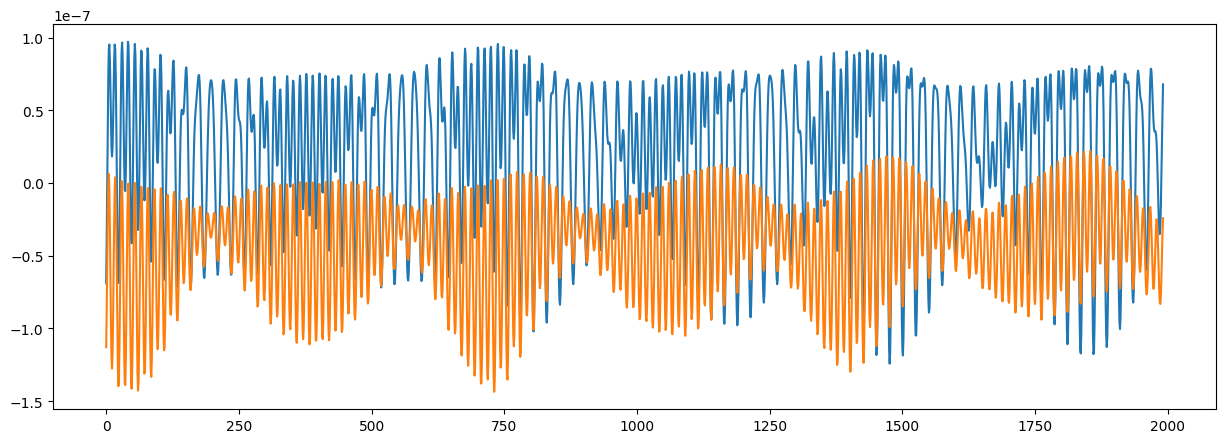

In [14]:
plt.figure(figsize=(15,5))
plt.plot(tideN2*1e-1)
plt.plot(tideN)

In [15]:
gtide = Stream()

gtideN = Trace()
gtideN.data = tideN
gtideN.stats.delta = 3600
gtideN.stats.starttime = config['tbeg']
gtideN.stats.station = "GTID"
gtideN.stats.channel = "LAN"
gtideN.stats.network = "BW"

gtideE = Trace()
gtideE.data = tideE
gtideE.stats.delta = 3600
gtideE.stats.starttime = config['tbeg']
gtideE.stats.station = "GTID"
gtideE.stats.channel = "LAE"
gtideE.stats.network = "BW"

gtide += gtideE
gtide += gtideN

In [297]:
tilts = Stream()

tilts += tromy0.merge(fill_value="interpolate").select(channel="*N")[0].copy()
tilts += tromy0.merge(fill_value="interpolate").select(channel="*E")[0].copy()

tilts += gtide.copy()

In [298]:

pmin, pmax, tides_str = 100, 2, "low"

tilts = tilts.detrend("linear")
tilts = tilts.taper(0.05, type="cosine")

Npad = 3*86400
for tr in tilts:
    tr.data = np.pad(tr.data, Npad, mode="edge")

tilts = tilts.filter("bandpass", freqmin=1/(pmin*3600), freqmax=1/(pmax*3600), corners=4, zerophase=True)

for tr in tilts:
    tr.data = tr.data[Npad:-Npad]

# for tr in tilts:
#     tr.data = tr.data * 10

tilts = tilts.resample(1/3600, no_filter=True)
# tilts = tilts.decimate(10)
tilts = tilts.trim(config['tbeg'], config['tend'], nearest_sample=True)
tilts

4 Trace(s) in Stream:
BW.ROMYT..MAN | 2024-03-08T23:59:59.934999Z - 2024-05-30T22:59:59.934999Z | 3600.0 s, 1992 samples
BW.ROMYT..MAE | 2024-03-08T23:59:59.935000Z - 2024-05-30T22:59:59.935000Z | 3600.0 s, 1992 samples
BW.GTID..LAE  | 2024-03-09T00:00:00.000000Z - 2024-05-30T23:00:00.000000Z | 3600.0 s, 1992 samples
BW.GTID..LAN  | 2024-03-09T00:00:00.000000Z - 2024-05-30T23:00:00.000000Z | 3600.0 s, 1992 samples

### Plot CWT of Tilt

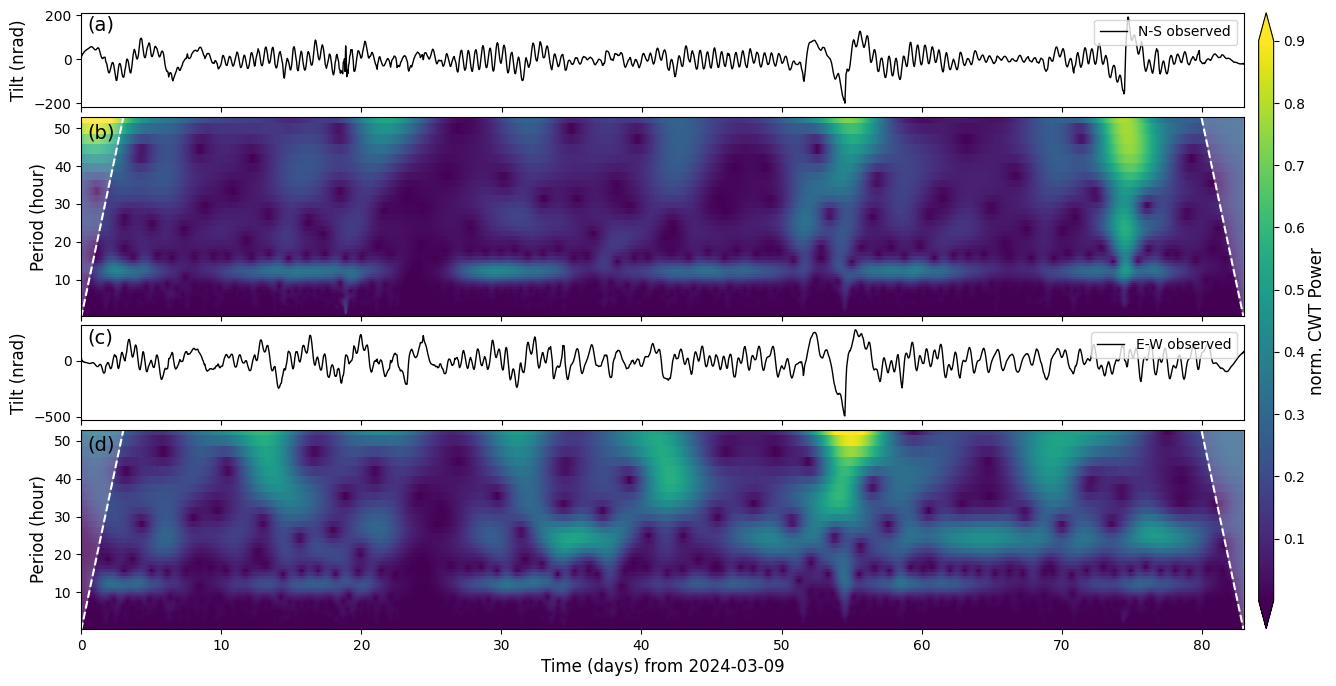

In [277]:
def __makeplot_cwt_all():

    import matplotlib.pyplot as plt
    import numpy as np
    from matplotlib.gridspec import GridSpec

    def __rmse(arr1, arr2):
        return np.round(np.sqrt(np.mean((arr1-arr2)**2)), 2)

    tscale = 1/86400

    times = tilts.select(channel="*N")[0].times()*tscale

    Ncol, Nrow = 1, 6

    font = 12

    lw = 1

    cmap = plt.get_cmap("viridis")

    tilt_scale, tilt_unit = 1e9, f"nrad"

    fig = plt.figure(figsize=(15, 8))

    gs = GridSpec(Nrow, Ncol, figure=fig, hspace=0.1)

    ax1 = fig.add_subplot(gs[0, :])
    ax2 = fig.add_subplot(gs[1:3, :])
    ax3 = fig.add_subplot(gs[3, :])
    ax4 = fig.add_subplot(gs[4:6, :])

    axes = [ax1, ax2, ax3, ax4]

    N1 = tilts.select(station="ROMYT", channel="*N")[0].data*tilt_scale
    E1 = tilts.select(station="ROMYT", channel="*E")[0].data*tilt_scale
    periodN = 1/outN['frequencies']/3600
    periodE = 1/outE['frequencies']/3600


    ax1.plot(times, N1, color="k", label="N-S observed", lw=lw)
    ax1.set_xlim(min(times), max(times))
    ax1.legend(loc=1)
    ax1.set_xticklabels([])

    im1 = ax2.pcolormesh(outN['times']*tscale*3600, periodN, outN['cwt_power'],
                         cmap=cmap,
                         vmin=np.nanmin(np.reshape(outN['cwt_power'], outN['cwt_power'].size)*1.1),
                         vmax=np.nanmax(np.reshape(outN['cwt_power'], outN['cwt_power'].size)*0.9),
                        )
    ax2.plot(outN['times']*tscale*3600, 1/outN['cone']/3600, color="white", ls="--")
    ax2.fill_between(outN['times']*tscale*3600, 1/outN['cone']/3600, max(periodN)*np.ones(len(outN['cone'])), color="white", alpha=0.2)
    ax2.set_ylim(min(periodN), max(periodN))
    ax2.set_xticklabels([])

    ax3.plot(times, E1, color="k", label="E-W observed", lw=lw)
    ax3.set_xlim(min(times), max(times))
    ax3.legend(loc=1)
    ax3.set_xticklabels([])

    im2 = ax4.pcolormesh(outE['times']*tscale*3600, periodE, outE['cwt_power'],
                         cmap=cmap,
                         vmin=np.nanmin(np.reshape(outN['cwt_power'], outN['cwt_power'].size)*1.1),
                         vmax=np.nanmax(np.reshape(outN['cwt_power'], outN['cwt_power'].size)*0.9),
                        )
    ax4.plot(outE['times']*tscale*3600, 1/outE['cone']/3600, color="white", ls="--")
    ax4.fill_between(outE['times']*tscale*3600, 1/outE['cone']/3600, max(periodE)*np.ones(len(outE['cone'])), color="white", alpha=0.2)
    ax4.set_ylim(min(periodE), max(periodE))


    ax1.set_ylabel(f"Tilt ({tilt_unit})", fontsize=font)
    ax2.set_ylabel(f"Period (hour)", fontsize=font)
    ax3.set_ylabel(f"Tilt ({tilt_unit})", fontsize=font)
    ax4.set_ylabel(f"Period (hour)", fontsize=font)
    ax4.set_xlabel(f"Time (days) from {config['tbeg'].date}", fontsize=font)


    ax1.text(.005, .97, "(a)", ha='left', va='top', transform=ax1.transAxes, fontsize=font+2)
    ax2.text(.005, .97, "(b)", ha='left', va='top', transform=ax2.transAxes, fontsize=font+2)
    ax3.text(.005, .97, "(c)", ha='left', va='top', transform=ax3.transAxes, fontsize=font+2)
    ax4.text(.005, .97, "(d)", ha='left', va='top', transform=ax4.transAxes, fontsize=font+2)

    # add colorbar
    cbar_ax = fig.add_axes([0.91, 0.11, 0.01, 0.77]) #[left, bottom, width, height]
    cb = plt.colorbar(im1, cax=cbar_ax, extend="both")
    cb.set_label("norm. CWT Power", fontsize=font, labelpad=2, color="black")

#     ax1.set_title(f"bandpass = {pmax} - {pmin} hours")

    plt.plot();
    return fig

fig = __makeplot_cwt_all()

# fig.savefig(config['path_to_figs']+f"SF_Tilt_cwt_{config['date_str']}_{tides_str}.png", format="png", dpi=150, bbox_inches='tight')

del fig

## Tides

In [305]:
tilts1 = tilts.copy()

pmin, pmax, tides_str = 26, 10, "both"
# pmin, pmax, tides_str = 25, 22, "24hr"
# pmin, pmax, tides_str = 14, 10, "12hr"

tilts1 = tilts1.filter("bandpass", freqmin=1/(pmin*3600), freqmax=1/(pmax*3600), corners=4, zerophase=True)


In [306]:
from functions.compute_orthogonal_distance_regression import __compute_orthogonal_distance_regression

tilt_scale = 1e9

N1 = tilts1.select(station="ROMYT", channel="*N")[0].data*tilt_scale
N2 = tilts1.select(station="GTID", channel="*N")[0].data*tilt_scale

Nmm, Ny0 = __compute_orthogonal_distance_regression(N2[:1500], N1[:1500])

E1 = tilts1.select(station="ROMYT", channel="*E")[0].data*tilt_scale
E2 = tilts1.select(station="GTID", channel="*E")[0].data*tilt_scale

Emm, Ey0 = __compute_orthogonal_distance_regression(E2[:1500], E1[:1500])

In [307]:
from obspy.signal.cross_correlation import correlate

In [308]:
correlate(E1, E2, shift=3), correlate(N1, N2, shift=3)

(array([0.15707298, 0.49326305, 0.75408812, 0.875891  , 0.82688909,
        0.61540708, 0.28807743]),
 array([0.07903916, 0.50650272, 0.80793103, 0.90623895, 0.77609997,
        0.45038078, 0.01168987]))

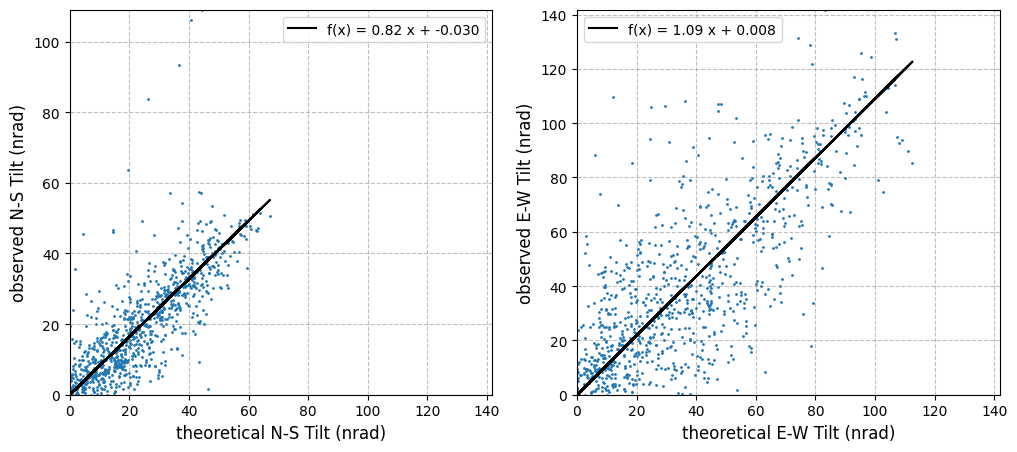

In [309]:
def __makeplot():

    import matplotlib.pyplot as plt

    Nrow, Ncol = 1, 2

    font = 12

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(12, 5), sharex=True)

    plt.subplots_adjust(hspace=0.1)

    ax[0].scatter(N2, N1, s=1)
    ax[0].plot(N2, N2*Nmm+Ny0, "k", label=f"f(x) = {Nmm:.2f} x + {Ny0:.3f}")

    ax[1].scatter(E2, E1, s=1)
    ax[1].plot(E2, E2*Emm+Ey0, "k", label=f"f(x) = {Emm:.2f} x + {Ey0:.3f}")

    # ax.set_xscale("log")

    # ax.set_ylim(0, 8000)
    Emax = max([max(E1), max(E2)])
    Nmax = max([max(N1), max(N2)])
    maxs = [Nmax, Emax]
    for i in range(Ncol):
        ax[i].grid(which="both", ls="--", color="grey", alpha=0.5, zorder=0)
        ax[i].set_xlim(0, maxs[i])
        ax[i].set_ylim(0, maxs[i])
        ax[i].legend()

    ax[0].set_xlabel("theoretical N-S Tilt (nrad)", fontsize=font)
    ax[1].set_xlabel("theoretical E-W Tilt (nrad)", fontsize=font)

    ax[0].set_ylabel("observed N-S Tilt (nrad)", fontsize=font)
    ax[1].set_ylabel("observed E-W Tilt (nrad)", fontsize=font)

    plt.show();
    return fig

fig = __makeplot();


N: 0.821 | E: 1.090


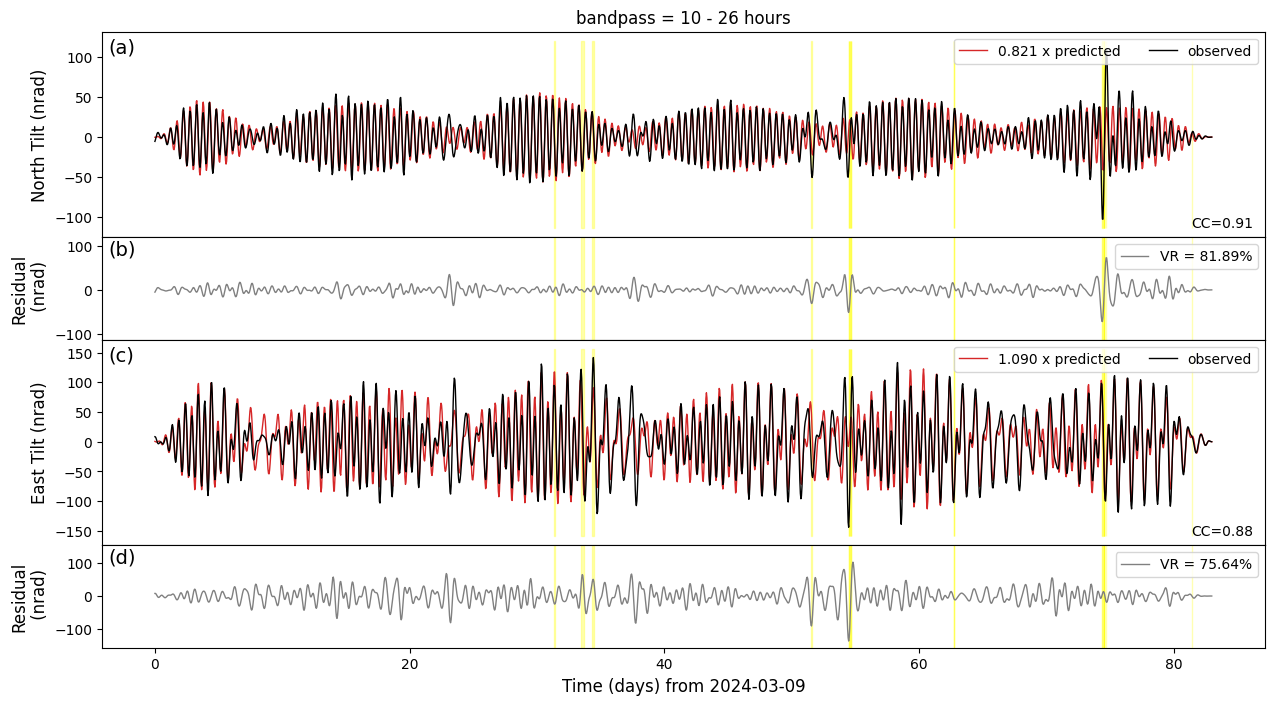

In [311]:
def __makeplot(_tilts):

    import matplotlib.pyplot as plt
    import numpy as np
    from matplotlib.gridspec import GridSpec
    from functions.compute_orthogonal_distance_regression import __compute_orthogonal_distance_regression
    from functions.variance_reduction import __variance_reduction
    from obspy.signal.cross_correlation import correlate

    def __rmse(arr1, arr2):
        return np.round(np.sqrt(np.mean((arr1-arr2)**2)), 2)

    tilt_scale, tilt_unit = 1e9, f"nrad"

    tscale = 1/86400

    times = _tilts.select(channel="*N")[0].times()*tscale

    N1 = _tilts.select(station="ROMYT", channel="*N")[0].data*tilt_scale
    N2 = _tilts.select(station="GTID", channel="*N")[0].data*tilt_scale

    E1 = _tilts.select(station="ROMYT", channel="*E")[0].data*tilt_scale
    E2 = _tilts.select(station="GTID", channel="*E")[0].data*tilt_scale

    CCE, CCN = correlate(E1, E2, shift=0)[0], correlate(N1, N2, shift=0)[0]

    # linear relation
    Nx = 1500
    Nmm, Ny0 = __compute_orthogonal_distance_regression(N2[:Nx], N1[:Nx])
    Emm, Ey0 = __compute_orthogonal_distance_regression(E2[:Nx], E1[:Nx])

    # scale theo. tilt
    N2 = N2*Nmm
    E2 = E2*Emm

    print(f"N: {Nmm:.3f} | E: {Emm:.3f}")

    # compute variance reduction
    N_vr = __variance_reduction(N1, N1-N2)
    E_vr = __variance_reduction(E1, E1-E2)

    # compute RMSE
    # N_rmse = __rmse(RN, PN)
    # E_rmse = __rmse(RE, PE)

    # _________________________________________

    Ncol, Nrow = 1, 6

    font = 12
    lw = 1

    fig = plt.figure(figsize=(15, 8))

    gs = GridSpec(Nrow, Ncol, figure=fig, hspace=0)

    ax1 = fig.add_subplot(gs[0:2, :])
    ax2 = fig.add_subplot(gs[2, :])
    ax3 = fig.add_subplot(gs[3:5, :])
    ax4 = fig.add_subplot(gs[5, :])

    ax1.plot(times, N2, color="tab:red", label=f"{Nmm:.3f} x predicted", ls="-", lw=lw)
    ax1.plot(times, N1, color="k", label="observed", lw=lw)

    ax2.plot(times, (N1-N2), color="grey", label=f"VR = {N_vr}%", lw=lw)

    ax3.plot(times, E2, color="tab:red", label=f"{Emm:.3f} x predicted", ls="-", lw=lw)
    ax3.plot(times, E1, color="k", label="observed", lw=lw)

    ax4.plot(times, (E1-E2), color="grey", label=f"VR = {E_vr}%", lw=lw)

    ax2.set_ylim(ax1.get_ylim())
    ax4.set_ylim(ax3.get_ylim())

    for ax in [ax1, ax2, ax3, ax4]:
        ax.legend(loc=1, ncol=2)

        _ymin, _ymax = ax.get_ylim()

        # add maintenance times
        for lx1, lx2 in zip(lxx_t1, lxx_t2):
            lx1_sec = lx1-UTCDateTime(config['tbeg'])
            lx2_sec = lx2-UTCDateTime(config['tbeg'])
            ax.fill_betweenx([_ymin, _ymax], lx1_sec*tscale, lx2_sec*tscale, color="yellow", alpha=0.3)

    ax1.set_ylabel(f"North Tilt ({tilt_unit})", fontsize=font)
    ax2.set_ylabel(f"Residual\n ({tilt_unit})", fontsize=font)
    ax3.set_ylabel(f"East Tilt ({tilt_unit})", fontsize=font)
    ax4.set_ylabel(f"Residual\n ({tilt_unit})", fontsize=font)
    ax4.set_xlabel(f"Time (days) from {config['tbeg'].date}", fontsize=font)

    ax1.text(.005, .97, "(a)", ha='left', va='top', transform=ax1.transAxes, fontsize=font+2)
    ax2.text(.005, .97, "(b)", ha='left', va='top', transform=ax2.transAxes, fontsize=font+2)
    ax3.text(.005, .97, "(c)", ha='left', va='top', transform=ax3.transAxes, fontsize=font+2)
    ax4.text(.005, .97, "(d)", ha='left', va='top', transform=ax4.transAxes, fontsize=font+2)

    ax1.text(.99, .1, f"CC={round(CCN, 2)}", ha='right', va='top', transform=ax1.transAxes, fontsize=font-2)
    ax3.text(.99, .1, f"CC={round(CCE, 2)}", ha='right', va='top', transform=ax3.transAxes, fontsize=font-2)

    ax1.set_title(f"bandpass = {pmax} - {pmin} hours")

    plt.plot();
    return fig

fig = __makeplot(tilts1)

fig.savefig(config['path_to_figs']+f"SF_Tilt_predicted_tides_{config['date_str']}_{tides_str}.png", format="png", dpi=150, bbox_inches='tight')

del fig

## Add Air Pressure

In [312]:
def __find_model(ddf, _features, target="fj_fs", reg="theilsen"):

    from sklearn import linear_model
    from sklearn.linear_model import LinearRegression, RANSACRegressor, HuberRegressor, TheilSenRegressor

    _df = ddf.copy()

    # remove time and target
    try:
        _features.remove(target)
    except:
        pass
    try:
        _features.remove("time")
    except:
        pass

    print(_features)

    # define x data
    X = _df[_features].values.reshape(-1, len(_features))

    # define y data
    y = _df[target].values

    # multi linear regression

    # using OLS
    if reg.lower() == "ols":
        ols = linear_model.LinearRegression()
        model = ols.fit(X, y)

        print("R2:", model.score(X, y))
        print("X0:",  model.intercept_)
        print("Coef: ",  model.coef_)
        for _f, _c in zip(_features, model.coef_):
            print(f"{_f} : {_c}")

    elif reg.lower() == "ransac":
        model = RANSACRegressor(random_state=1).fit(X, y)
        print("R2:", model.score(X, y))
        print("IC: ", model.estimator_.intercept_)
        print("Coef: ",  model.estimator_.coef_)
        for _f, _c in zip(_features, model.estimator_.coef_):
            print(f"{_f} : {_c}")

    # using TheilSen
    elif reg.lower() == "theilsen":
        model = TheilSenRegressor().fit(X, y)

        print("R2:", model.score(X, y))
        print("X0:",  model.intercept_)
        print("Coef: ",  model.coef_)
        for _f, _c in zip(_features, model.coef_):
            print(f"{_f} : {_c}")

    # prediction
    model_predict = []

    for o, row in _df[_features].iterrows():

        x_pred = []
        for feat in _features:
            x_pred.append(row[feat])

        x_pred = np.array(x_pred)
        x_pred = x_pred.reshape(-1, len(_features))

        model_predict.append(model.predict(x_pred))

    out = {}
    out['model'] = model
    out['r2'] = model.score(X, y)
    out['tp'] = _df.time
    out['dp'] = model_predict

    try:
        out['slope'] = float(model.estimator_.coef_)
        out['inter'] = float(model.estimator_.intercept_)
    except:
        pass

    # plt.plot(_df.time, model_predict)
    # plt.plot(_df.time, _df[target].values)

    return out

In [313]:
ffbi0 = __read_sds(archive_path+"temp_archive/", "BW.FFBI.30.LDO", config['tbeg'], config['tend'])

In [314]:
ffbi = ffbi0.copy()

ffbi = ffbi.detrend("linear")
ffbi = ffbi.taper(0.05, type="cosine")

Npad = 3*86400
for tr in ffbi:
    tr.data = np.pad(tr.data, Npad, mode="edge")

ffbi = ffbi.filter("bandpass", freqmin=1/(pmin*3600), freqmax=1/(pmax*3600), corners=4, zerophase=True)

for tr in ffbi:
    tr.data = tr.data[Npad:-Npad]

ffbi = ffbi.resample(1/3600, no_filter=True)


### Add to tilt stream

In [370]:
tilts2 = tilts.copy()

tilts2 += ffbi.copy()

### Correct observed tilts with predictions

In [371]:
# tilts2.select(station="ROMYT", channel="*N")[0].data -= tilts2.select(station="GTID", channel="*N")[0].data
# tilts2.select(station="ROMYT", channel="*E")[0].data -= tilts2.select(station="GTID", channel="*E")[0].data

In [372]:
pmin, pmax, tides_str = 30, 1, "ffbi"

tilts2 = tilts2.filter("bandpass", freqmin=1/(pmin*3600), freqmax=1/(pmax*3600), corners=4, zerophase=True)

In [373]:
from functions.regression import __regression

### Plotting

In [374]:
# def __makeplot(_tilts):

#     import matplotlib.pyplot as plt
#     import numpy as np
#     from matplotlib.gridspec import GridSpec
#     from functions.compute_orthogonal_distance_regression import __compute_orthogonal_distance_regression
#     from functions.variance_reduction import __variance_reduction

#     def __rmse(arr1, arr2):
#         return np.round(np.sqrt(np.mean((arr1-arr2)**2)), 2)

#     tilt_scale, tilt_unit = 1e9, f"nrad"

#     tscale = 1/86400

#     times = _tilts.select(channel="*N")[0].times()*tscale

#     N1 = _tilts.select(station="ROMYT", channel="*N")[0].data*tilt_scale
#     N2 = _tilts.select(station="GTID", channel="*N")[0].data*tilt_scale

#     E1 = _tilts.select(station="ROMYT", channel="*E")[0].data*tilt_scale
#     E2 = _tilts.select(station="GTID", channel="*E")[0].data*tilt_scale

#     Nx = 1500
#     Nmm, Ny0 = __compute_orthogonal_distance_regression(N2[:Nx], N1[:Nx])
#     Emm, Ey0 = __compute_orthogonal_distance_regression(E2[:Nx], E1[:Nx])

#     # compute residual time series
#     RN = N1 - N2*Nmm
#     RE = E1 - E2*Emm

#     # get pressure time series
#     PP = _tilts.select(station="FFBI", channel="*O")[0].data

#     # find scaling for Pressure and Tilt
#     # Nx = len(PP)

#     # PNm, PNy = __compute_orthogonal_distance_regression(PP[:Nx], RN[:Nx])
#     # PEm, PEy = __compute_orthogonal_distance_regression(PP[:Nx], RE[:Nx])


#     out = __find_model(_tilts_df, ['PP'], target='RE', reg="ransac")
#     PEm, PEy = out['slope'], out['inter']

#     out = __find_model(_tilts_df, ['PP'], target='RN', reg="ransac")
#     PNm, PNy = out['slope'], out['inter']

#     print(f"N: {PNm:.3f} | E: {PEm:.3f}")

#     # scale pressue to tilt
#     PN = PP * PNm
#     PE = PP * PEm

#     # compute variance reduction
#     N_vr = __variance_reduction(RN, RN-PN)
#     E_vr = __variance_reduction(RE, RE-PE)

#     N_rmse = __rmse(RN, PN)
#     E_rmse = __rmse(RE, PE)

#     # _________________________________________________________

#     Ncol, Nrow = 1, 6

#     font = 12
#     lw = 1

#     fig = plt.figure(figsize=(15, 8))

#     gs = GridSpec(Nrow, Ncol, figure=fig, hspace=0)

#     ax1 = fig.add_subplot(gs[0:2, :])
#     ax2 = fig.add_subplot(gs[2, :])
#     ax3 = fig.add_subplot(gs[3:5, :])
#     ax4 = fig.add_subplot(gs[5, :])

#     ax1.plot(times, PN, color="tab:red", label=f"{PNm:.3f} {tilt_unit}/hPa x FFBI.BDO", ls="-", lw=lw)
#     ax1.plot(times, RN, color="k", label="residual", lw=lw)

#     ax2.plot(times, (RN-PN), color="grey", label=f"VR = {N_vr}%", lw=lw)

#     ax3.plot(times, PE, color="tab:red", label=f"{PEm:.3f} {tilt_unit}/hPa x FFBI.BDO", ls="-", lw=lw)
#     ax3.plot(times, RE, color="k", label="residual", lw=lw)

#     ax4.plot(times, (RE-PE), color="grey", label=f"VR = {E_vr}%", lw=lw)

#     ax2.set_ylim(ax1.get_ylim())
#     ax4.set_ylim(ax3.get_ylim())

#     for ax in [ax1, ax2, ax3, ax4]:
#         ax.legend(loc=1, ncol=2)

#         _ymin, _ymax = ax.get_ylim()

#         # add maintenance times
#         for lx1, lx2 in zip(lxx_t1, lxx_t2):
#             lx1_sec = lx1-UTCDateTime(config['tbeg'])
#             lx2_sec = lx2-UTCDateTime(config['tbeg'])
#             ax.fill_betweenx([_ymin, _ymax], lx1_sec*tscale, lx2_sec*tscale, color="yellow", alpha=0.3)

#     ax1.set_ylabel(f"North Tilt ({tilt_unit})", fontsize=font)
#     ax2.set_ylabel(f"Residual\n ({tilt_unit})", fontsize=font)
#     ax3.set_ylabel(f"East Tilt ({tilt_unit})", fontsize=font)
#     ax4.set_ylabel(f"Residual\n ({tilt_unit})", fontsize=font)
#     ax4.set_xlabel(f"Time (days) from {config['tbeg'].date}", fontsize=font)


#     ax1.text(.005, .97, "(a)", ha='left', va='top', transform=ax1.transAxes, fontsize=font+2)
#     ax2.text(.005, .97, "(b)", ha='left', va='top', transform=ax2.transAxes, fontsize=font+2)
#     ax3.text(.005, .97, "(c)", ha='left', va='top', transform=ax3.transAxes, fontsize=font+2)
#     ax4.text(.005, .97, "(d)", ha='left', va='top', transform=ax4.transAxes, fontsize=font+2)

#     ax1.set_title(f"bandpass = {pmax} - {pmin} hours")

#     plt.plot();
#     return fig

# fig = __makeplot(tilts2)

# fig.savefig(config['path_to_figs']+f"SF_Tilt_Pressure_{config['date_str']}_{tides_str}.png", format="png", dpi=150, bbox_inches='tight')

# del fig

In [380]:
tilts_df = DataFrame()
tilts_df['time'] = tilts2[0].times()
tilts_df['PP'] = tilts2.select(station="FFBI", channel="*O")[0].data
tilts_df['N0'] = tilts2.select(station="ROMYT", channel="*N")[0].data
tilts_df['E0'] = tilts2.select(station="ROMYT", channel="*E")[0].data
tilts_df['HP'] = np.imag(hilbert(tilts_df['PP']))

tilts_df['EP'] = tilts2.select(station="GTID", channel="*E")[0].data
tilts_df['NP'] = tilts2.select(station="GTID", channel="*N")[0].data


# regression for prediction and observations
out = __regression(tilts_df, ['EP'], target='E0', reg="ransac")
PEm0, PEy0 = out['slope'][0], out['inter']

out = __regression(tilts_df, ['NP'], target='N0', reg="ransac")
PNm0, PNy0 = out['slope'][0], out['inter']

print(f"\nN: {PNm0} | E: {PEm0}\n")

# no regression
PNm0 = 1
PEm0 = 1

# PNm0 = 0.82
# PEm0 = 1.09

# compute residual time series
tilts_df['RN'] = tilts_df['N0'] - tilts_df['NP']*PNm0
tilts_df['RE'] = tilts_df['E0'] - tilts_df['EP']*PEm0


# regression with barometer model
out = __regression(tilts_df, ['PP', 'HP'], target='RE', reg="ransac")
PEm, PEy = out['slope'], out['inter']

out = __regression(tilts_df, ['PP', 'HP'], target='RN', reg="ransac")
PNm, PNy = out['slope'], out['inter']

print(f"\nN: {PNm} | E: {PEm}\n")

tilts_df['Nmodel'] = PNm[0] * tilts_df['PP'] + PNm[1] * tilts_df['HP']
tilts_df['Emodel'] = PEm[0] * tilts_df['PP'] + PEm[1] * tilts_df['HP']

# scale pressue to tilt
tilts_df['Nres'] = tilts_df['RN'] - tilts_df['Nmodel']
tilts_df['Eres'] = tilts_df['RE'] - tilts_df['Emodel']

modelN = f"{PNm[0]*1e9:.1f} nrad/hPa x P + {PNm[1]*1e9:.1f} nrad/hPa x H[P]"
modelE = f"{PEm[0]*1e9:.1f} nrad/hPa x P + {PEm[1]*1e9:.1f} nrad/hPa x H[P]"

R2: 0.729236597875702
IC:  1.7685651749214153e-09
Coef:  [0.97697506]
EP : 0.9769750584634612
R2: 0.7739349548344652
IC:  1.2197436824494756e-09
Coef:  [0.72365116]
NP : 0.7236511645422372

N: 0.7236511645422372 | E: 0.9769750584634612

R2: 0.4346837387774496
IC:  -2.0483938749591205e-09
Coef:  [2.80379497e-08 1.01269283e-08]
PP : 2.803794974789866e-08
HP : 1.0126928343046318e-08
R2: 0.13230504645039454
IC:  -3.352475230788324e-10
Coef:  [-5.25996627e-09  8.38242129e-09]
PP : -5.25996627364562e-09
HP : 8.382421285377355e-09

N: [-5.25996627e-09  8.38242129e-09] | E: [2.80379497e-08 1.01269283e-08]



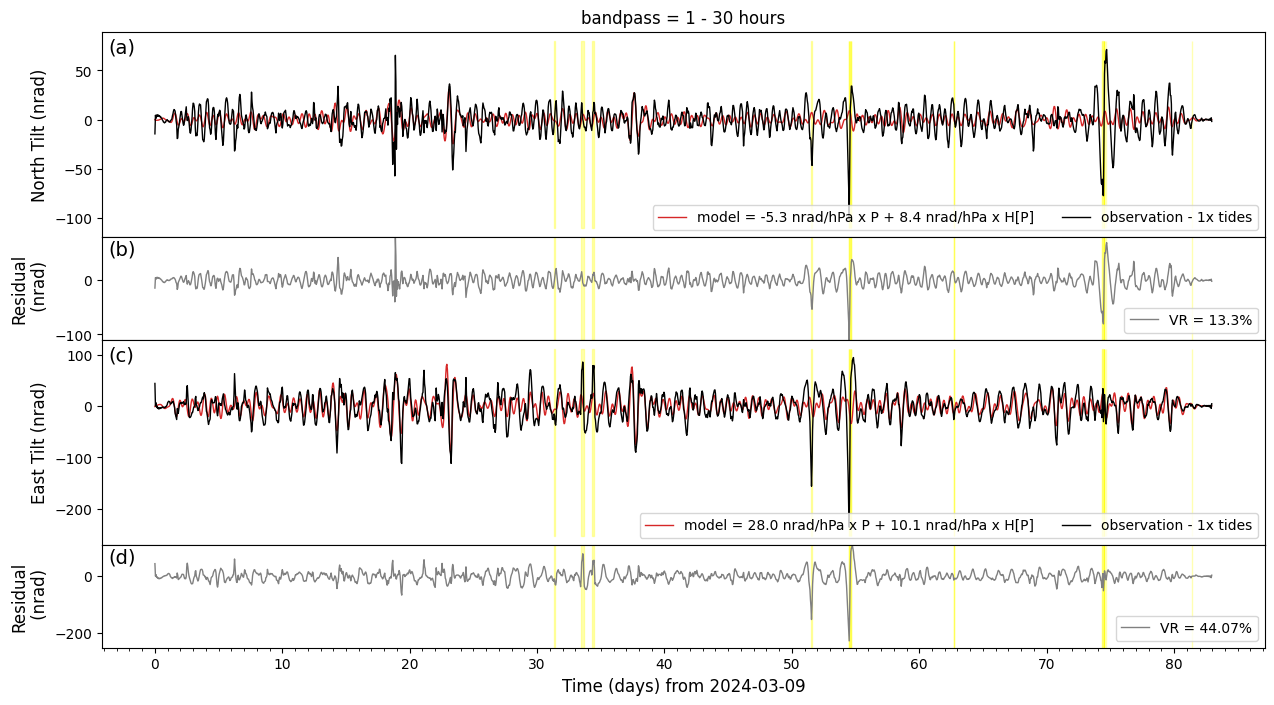

In [382]:
def __makeplot(_df):

    import matplotlib.pyplot as plt
    import numpy as np

    from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
    from matplotlib.gridspec import GridSpec
    from functions.compute_orthogonal_distance_regression import __compute_orthogonal_distance_regression
    from functions.variance_reduction import __variance_reduction

    def __rmse(arr1, arr2):
        return np.round(np.sqrt(np.mean((arr1-arr2)**2)), 2)

    tilt_scale, tilt_unit = 1e9, f"nrad"

    tscale = 1/86400

    times = _df['time']*tscale

    # compute variance reduction
    N_vr = __variance_reduction(_df['RN'], _df['Nres'])
    E_vr = __variance_reduction(_df['RE'], _df['Eres'])

    # _________________________________________________________

    Ncol, Nrow = 1, 6

    font = 12
    lw = 1

    fig = plt.figure(figsize=(15, 8))

    gs = GridSpec(Nrow, Ncol, figure=fig, hspace=0)

    ax1 = fig.add_subplot(gs[0:2, :])
    ax2 = fig.add_subplot(gs[2, :])
    ax3 = fig.add_subplot(gs[3:5, :])
    ax4 = fig.add_subplot(gs[5, :])

    ax1.plot(times, _df['Nmodel']*tilt_scale, color="tab:red", label=f"model = {modelN}", ls="-", lw=lw)
    ax1.plot(times, _df['RN']*tilt_scale, color="k", label=f"observation - {round(PNm0, 2)}x tides", lw=lw)

    ax2.plot(times, _df['Nres']*tilt_scale, color="grey", label=f"VR = {N_vr}%", lw=lw)

    ax3.plot(times, _df['Emodel']*tilt_scale, color="tab:red", label=f"model = {modelE}", ls="-", lw=lw)
    ax3.plot(times, _df['RE']*tilt_scale, color="k", label=f"observation - {round(PEm0, 2)}x tides", lw=lw)

    ax4.plot(times, _df['Eres']*tilt_scale, color="grey", label=f"VR = {E_vr}%", lw=lw)

    ax2.set_ylim(ax1.get_ylim())
    ax4.set_ylim(ax3.get_ylim())

    for ax in [ax1, ax2, ax3, ax4]:
        ax.legend(loc=4, ncol=2)
        ax.xaxis.set_major_locator(MultipleLocator(10))
        ax.xaxis.set_minor_locator(MultipleLocator(1))

        _ymin, _ymax = ax.get_ylim()

        # add maintenance times
        for lx1, lx2 in zip(lxx_t1, lxx_t2):
            lx1_sec = lx1-UTCDateTime(config['tbeg'])
            lx2_sec = lx2-UTCDateTime(config['tbeg'])
            ax.fill_betweenx([_ymin, _ymax], lx1_sec*tscale, lx2_sec*tscale, color="yellow", alpha=0.3)

    ax1.set_ylabel(f"North Tilt ({tilt_unit})", fontsize=font)
    ax2.set_ylabel(f"Residual\n ({tilt_unit})", fontsize=font)
    ax3.set_ylabel(f"East Tilt ({tilt_unit})", fontsize=font)
    ax4.set_ylabel(f"Residual\n ({tilt_unit})", fontsize=font)
    ax4.set_xlabel(f"Time (days) from {config['tbeg'].date}", fontsize=font)

    ax1.text(.005, .97, "(a)", ha='left', va='top', transform=ax1.transAxes, fontsize=font+2)
    ax2.text(.005, .97, "(b)", ha='left', va='top', transform=ax2.transAxes, fontsize=font+2)
    ax3.text(.005, .97, "(c)", ha='left', va='top', transform=ax3.transAxes, fontsize=font+2)
    ax4.text(.005, .97, "(d)", ha='left', va='top', transform=ax4.transAxes, fontsize=font+2)

    ax1.set_title(f"bandpass = {pmax} - {pmin} hours")

    plt.plot();
    return fig

fig = __makeplot(tilts_df)

fig.savefig(config['path_to_figs']+f"SF_Tilt_Pressure_{config['date_str']}_{tides_str}.png", format="png", dpi=150, bbox_inches='tight')

del fig

In [377]:
def __makeplot(_df):

    import matplotlib.pyplot as plt

    tilt_scale, tilt_unit = 1e9, f"nrad"

    times = _df.time/86400

    # __________________________________________________________

    Nrow, Ncol = 1, 2

    font = 12

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(12, 5), sharex=True)

    plt.subplots_adjust(hspace=0.1)

    ax[0].scatter(_df['PP'], _df['RN'], s=1)
    ax[0].plot(_df['PP'], PNm[0]*_df['PP']+PNy[0], "k", label=f"f(x) = {modelN}")

    ax[1].scatter(_df['PP'], _df['RE'], s=1)
    ax[1].plot(_df['PP'], PEm[0]*_df['PP']+PEy[0], "k", label=f"f(x) = {modelE}")

    for i in range(Ncol):
        ax[i].grid(which="both", ls="--", color="grey", alpha=0.5, zorder=0)
        ax[i].legend()

    ax[0].set_ylabel("residual N-S Tilt (nrad)", fontsize=font)
    ax[1].set_ylabel("residual E-W Tilt (nrad)", fontsize=font)

    ax[0].set_xlabel("relative Pressure (hPa)", fontsize=font)
    ax[1].set_xlabel("relative Pressure (hPa)", fontsize=font)

    plt.show();
    return fig

# fig = __makeplot(tilts_df);


In [334]:
def __makeplot():

    import matplotlib.pyplot as plt

    Nrow, Ncol = 2, 1

    font = 12

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(12, 5), sharex=True)

    plt.subplots_adjust(hspace=0.1)

    ax[0].plot(Tres, Eres)
    ax[1].plot(Tres, Nres)

    ax000 = ax[0].twinx()
    ax000.plot(tt, pp, c="k", alpha=0.5)
    ax[0].set_yticks(np.linspace(ax[0].get_yticks()[0], ax[0].get_yticks()[-1], len(ax[0].get_yticks())))
    ax000.set_yticks(np.linspace(ax000.get_yticks()[0], ax000.get_yticks()[-1], len(ax[0].get_yticks())))

    ax111 = ax[1].twinx()
    ax111.plot(tt, pp, c="k", alpha=0.5)
    ax[1].set_yticks(np.linspace(ax[1].get_yticks()[0], ax[1].get_yticks()[-1], len(ax[1].get_yticks())))
    ax111.set_yticks(np.linspace(ax111.get_yticks()[0], ax111.get_yticks()[-1], len(ax[1].get_yticks())))

#     ax.set_xscale("log")
#     ax.set_ylim(0, 8000)

    # ax.grid(which="both", ls="--", color="grey", alpha=0.5, zorder=0)

    plt.show();
    return fig

# fig = __makeplot();
